# Bayesian Machine Learning Final Project 
### Diyu Zheng, Taylor Rohrich, Congxin (David) Xu



In [24]:
import pandas as pd
import pymc3 as pm
import sklearn.model_selection
import sklearn
from pandas_profiling import ProfileReport
import arviz as az
import seaborn as sns
import numpy as np
np.random.seed(0)

## Data Cleaning

#### Read this for full data

In [25]:
data = pd.read_csv('small.csv', low_memory=False)

In [26]:
# Identify the response variable
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'],
      dtype=object)

In [27]:
# Distribution of the response variable
data.loan_status.value_counts()

Fully Paid            4885
Charged Off           1274
Current                149
In Grace Period          5
Late (31-120 days)       1
Default                  1
Late (16-30 days)        1
Name: loan_status, dtype: int64

In [28]:
# For Simplicity, we are only going to assume that all data are either 'Default' or `Fully Paid`
data.loc[data['loan_status'] == 'Charged Off', 'loan_status'] = 'Default'
data.loc[data['loan_status'] != 'Default', 'loan_status'] = 'Fully Paid'
data.loan_status.value_counts()

Fully Paid    5041
Default       1275
Name: loan_status, dtype: int64

### Split training and test data
We are going to split the original data into 2 parts, training data and testing data. The Bayesian Logistic Regression model and the Naive Bayes model will only uses the training data to train the model and later, use the test data to generate forecast accuracy metrics and compare the performance with each other.

In [29]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.2)
train.loan_status.value_counts()

Fully Paid    4046
Default       1006
Name: loan_status, dtype: int64

In [30]:
test.loan_status.value_counts()

Fully Paid    995
Default       269
Name: loan_status, dtype: int64

In [31]:
# Convert to integers
train['loan_status'] = train['loan_status'].map({'Fully Paid':0, 'Default':1})
test['loan_status'] = test['loan_status'].map({'Fully Paid':0, 'Default':1})

<ipython-input-31-52aa32fe94d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['loan_status'] = train['loan_status'].map({'Fully Paid':0, 'Default':1})
<ipython-input-31-52aa32fe94d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['loan_status'] = test['loan_status'].map({'Fully Paid':0, 'Default':1})


In [32]:
# Select potential Predictors
# Changes these to proper names
column_selected = ['loan_status','annual_inc','chargeoff_within_12_mths',
                  'avg_cur_bal','int_rate','home_ownership',
                 'num_actv_bc_tl','num_actv_rev_tl','funded_amnt','grade','fico_range_high','tot_hi_cred_lim','last_fico_range_high','recoveries','total_rec_prncp']
data_selected = train[column_selected]

In [33]:
# Clean up variables from categories to integers
dist_lookup = dict(zip(data_selected['home_ownership'].unique(), range(len(data_selected['home_ownership'].unique()))))
data_selected['home_ownership'] = data_selected['home_ownership'].replace(dist_lookup)
data_selected['int_rate'] = data_selected['int_rate'].str.replace('%','').astype(float)
data_selected['grade'] = data_selected['grade'].map({'G':0,'F':1,"E":2,"D":3,"C":4,"B":5,'A':6})

<ipython-input-33-d9ec94c2ff2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['home_ownership'] = data_selected['home_ownership'].replace(dist_lookup)
<ipython-input-33-d9ec94c2ff2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['int_rate'] = data_selected['int_rate'].str.replace('%','').astype(float)
<ipython-input-33-d9ec94c2ff2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [34]:
# Scale data
def scale_column(col):
    return (col-np.mean(col))/np.std(col)
for column in data_selected.columns:
    if column not in ['loan_status','addr_state','home_ownership',]:
        data_selected[column] = scale_column(data_selected[column])

<ipython-input-34-a12f82114419>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected[column] = scale_column(data_selected[column])


In [35]:
data_selected.head()

,loan_status,annual_inc,chargeoff_within_12_mths,avg_cur_bal,int_rate,home_ownership,num_actv_bc_tl,num_actv_rev_tl,funded_amnt,grade,fico_range_high,tot_hi_cred_lim,last_fico_range_high,recoveries,total_rec_prncp
2070,0,-0.305454,-0.094063,-0.598111,1.208020,0,-0.731208,-0.527487,0.600093,-0.923401,-0.273741,-0.874092,-0.167391,-0.260653,0.818930
3042,0,-0.278077,-0.094063,1.782754,-1.106516,1,-1.165907,-1.113945,-0.153148,1.379555,3.522184,1.020272,1.456398,-0.260653,0.092711
2586,0,0.108372,-0.094063,1.549160,0.462818,1,-0.731208,0.058971,-1.285951,-0.155749,0.551460,2.446066,0.674574,-0.260653,-0.999454
2279,1,-0.873145,-0.094063,-0.490689,1.140696,2,-0.731208,-0.527487,-1.624321,-0.923401,-1.098942,-0.846467,-1.670898,-0.102151,-1.461288
575,1,-0.670809,-0.094063,-0.707030,0.541749,2,-0.731208,-0.820716,-0.974063,-0.155749,-0.603821,-0.934516,-0.768794,0.065293,-1.119573


## Naive Bayes Classifier
The Naive Bayes Classifier model is going to focus on the following variables: 
- `term`: Term of the load. "36 months" or "60 months"
- `grade`: Load Grade, A to G
- `sub_grade`: Each letter grade will have 6 subgrace, A1 to A6
- `emp_title`: Title of the employment of the borrower
- `emp_length`: The length of the employment
- `home_ownership`: Whether the borrows own a home.
- `purpose`: The purpose of taking the load
- `addr_state`: The state of the residence for the borrower.


In [36]:
# Select the categorical variable from the training data 
naive_column = [ 'loan_status', 'term','grade','sub_grade','emp_length','home_ownership','purpose','addr_state']
train_naive = train[naive_column].fillna('NA')
train_naive.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
2070,0,36 months,D,D5,NA,RENT,other,CA
3042,0,36 months,A,A5,4 years,MORTGAGE,house,CO
2586,0,36 months,C,C5,10+ years,MORTGAGE,home_improvement,NY
2279,1,36 months,D,D4,NA,OWN,debt_consolidation,WY
575,1,36 months,C,C5,< 1 year,OWN,debt_consolidation,LA


In [37]:
# Add Column Names to each of the values within that column
d_train = dict()
d_train['loan_status'] = list(train_naive.iloc[:, 0])

for i in range(1, len(train_naive.keys())):
    d_train[train_naive.keys()[i]] = list(train_naive.keys()[i] + "_" + train_naive.iloc[:, i])

new_train = pd.DataFrame(data = d_train)
new_train.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
0,0,term_ 36 months,grade_D,sub_grade_D5,emp_length_NA,home_ownership_RENT,purpose_other,addr_state_CA
1,0,term_ 36 months,grade_A,sub_grade_A5,emp_length_4 years,home_ownership_MORTGAGE,purpose_house,addr_state_CO
2,0,term_ 36 months,grade_C,sub_grade_C5,emp_length_10+ years,home_ownership_MORTGAGE,purpose_home_improvement,addr_state_NY
3,1,term_ 36 months,grade_D,sub_grade_D4,emp_length_NA,home_ownership_OWN,purpose_debt_consolidation,addr_state_WY
4,1,term_ 36 months,grade_C,sub_grade_C5,emp_length_< 1 year,home_ownership_OWN,purpose_debt_consolidation,addr_state_LA


In [38]:
# Perform the same data transformation on Test data
test_naive = test[naive_column].fillna('NA')
d_test = dict()
d_test['loan_status'] = list(test_naive.iloc[:, 0])

for i in range(1, len(test_naive.keys())):
    d_test[test_naive.keys()[i]] = list(test_naive.keys()[i] + "_" + test_naive.iloc[:, i])

new_test = pd.DataFrame(data = d_test)
new_test.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
0,0,term_ 60 months,grade_E,sub_grade_E2,emp_length_5 years,home_ownership_OWN,purpose_debt_consolidation,addr_state_CA
1,1,term_ 60 months,grade_F,sub_grade_F1,emp_length_3 years,home_ownership_RENT,purpose_other,addr_state_GA
2,0,term_ 60 months,grade_C,sub_grade_C4,emp_length_6 years,home_ownership_OWN,purpose_debt_consolidation,addr_state_NY
3,1,term_ 36 months,grade_B,sub_grade_B4,emp_length_10+ years,home_ownership_MORTGAGE,purpose_debt_consolidation,addr_state_MO
4,0,term_ 36 months,grade_A,sub_grade_A3,emp_length_10+ years,home_ownership_RENT,purpose_credit_card,addr_state_NY


In [39]:
# For Topic = Fully Paid
# Create a train document of words
train_FP_document = new_train[new_train['loan_status'] == 0]. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()

# Count the number of features occured in training data for Fully Paid
train_FP_count = dict()
for i in train_FP_document:
    if i not in train_FP_count:
        train_FP_count[i] = 0
    else:
        train_FP_count[i] += 1
        
# Get the total number of words occured and number of unique features
FP_total = sum(train_FP_count.values())
FP_count = len(train_FP_count.keys())

# Define alpha 
alpha = 1.5

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_FP_count):
    train_FP_count[value] = (train_FP_count[value] + alpha) / \
          (FP_total + alpha * FP_count)

In [40]:
# For Topic = Default
# Create a train document of words
train_DT_document = new_train[new_train['loan_status'] == 1]. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()

# Count the number of features occured in training data for Default
train_DT_count = dict()
for i in train_DT_document:
    if i not in train_DT_count:
        train_DT_count[i] = 0
    else:
        train_DT_count[i] += 1
        
# Get the total number of words occured and number of unique features
DT_total = sum(train_DT_count.values())
DT_count = len(train_DT_count.keys())

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_DT_count):
    train_DT_count[value] = (train_DT_count[value] + alpha) / \
          (DT_total + alpha * DT_count)

In [41]:
# Calculate the Posterior Probability for Test Data
new_test_FP_post = list()
new_test_DT_post = list()

for row in range(0, len(new_test)):
    FP_post = 1
    DT_post = 1
    for col in range(1, len(new_test.columns)):
        if (new_test.iloc[row, col] in train_FP_count): 
            FP_post = FP_post * \
              train_FP_count[new_test.iloc[row, col]]
        else:
            FP_post = FP_post * \
                (0 + alpha) / (FP_total + alpha * FP_count)
        
        if (new_test.iloc[row, col] in train_DT_count): 
            DT_post = DT_post * \
                train_DT_count[new_test.iloc[row, col]]
        else:
            DT_post = DT_post * \
                (0 + alpha) / (DT_total + alpha * DT_count)

    new_test_FP_post += [FP_post]   
    new_test_DT_post += [DT_post]

In [42]:
new_test.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
0,0,term_ 60 months,grade_E,sub_grade_E2,emp_length_5 years,home_ownership_OWN,purpose_debt_consolidation,addr_state_CA
1,1,term_ 60 months,grade_F,sub_grade_F1,emp_length_3 years,home_ownership_RENT,purpose_other,addr_state_GA
2,0,term_ 60 months,grade_C,sub_grade_C4,emp_length_6 years,home_ownership_OWN,purpose_debt_consolidation,addr_state_NY
3,1,term_ 36 months,grade_B,sub_grade_B4,emp_length_10+ years,home_ownership_MORTGAGE,purpose_debt_consolidation,addr_state_MO
4,0,term_ 36 months,grade_A,sub_grade_A3,emp_length_10+ years,home_ownership_RENT,purpose_credit_card,addr_state_NY


In [43]:
# Create a confusion matrix to evaluate prediction accuracy
actual = list()
predict = list()
for i in range(0, len(new_test)):
    if new_test.iloc[i,0] == 1:
        actual += [1]
    else:
        actual += [0]
        
    if new_test_DT_post[i] > new_test_FP_post[i]:
        predict += [1]
    else:
        predict += [0]

df_confusion = pd.crosstab(pd.Series(actual, name='actual'), pd.Series(predict, name='predict'))    
df_confusion

predict,0,1
actual,,
0,565,430
1,78,191


The total accuracy for the Naive Bayes Model is $$\frac{565 + 191}{565 + 430 + 78 + 191} = 59.81\%$$


## Bayesian Logistic Regression


For Bayesian Logistic Regression we will consider a full model and smaller models, removing correlated / statistically insignificant predictors.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tot_hi_cred_lim, fico_range_high, grade, num_actv_rev_tl, num_actv_bc_tl, int_rate, avg_cur_bal, total_rec_prncp, last_fico_range_high, intercept]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 92 seconds.


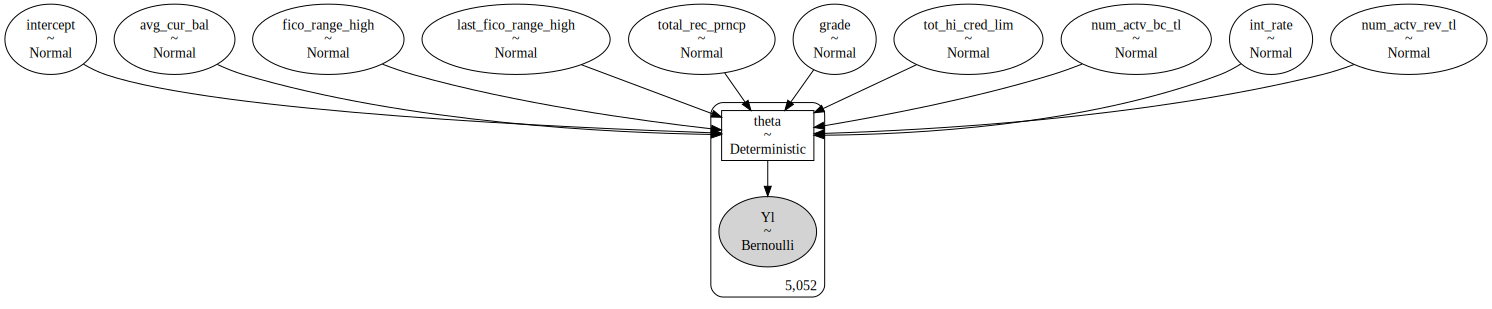

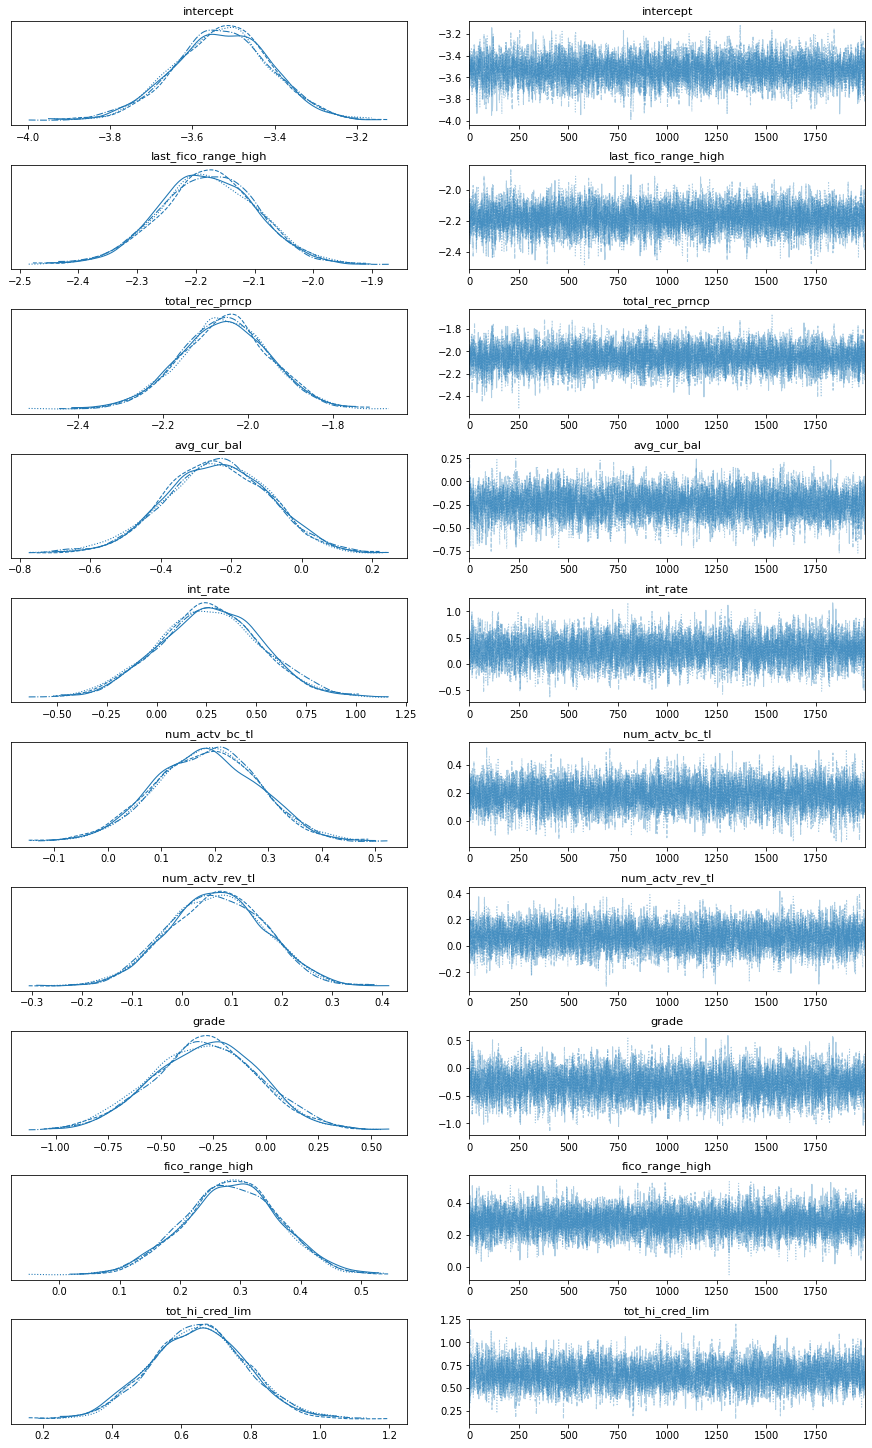

In [44]:
# Full Model Setup
with pm.Model() as full_model_sample:
    y = data_selected['loan_status']
    # Model Betas as uninformed gaussians
    b0 = pm.Normal('intercept', mu=0, sd=1e5) 
    b1 = pm.Normal('last_fico_range_high', mu=0, sd=1e5) 
    b2 = pm.Normal('total_rec_prncp', mu=0, sd=1e5)
    b3 = pm.Normal('avg_cur_bal', mu=0, sd=1e5)
    b4 = pm.Normal('int_rate', mu=0, sd=1e5)
    b5 = pm.Normal('num_actv_bc_tl', mu=0, sd=1e5)
    b6 = pm.Normal('num_actv_rev_tl', mu=0, sd=1e5)
    b7 = pm.Normal('grade', mu=0, sd=1e5)
    b8 = pm.Normal('fico_range_high', mu=0, sd=1e5)
    b9 = pm.Normal('tot_hi_cred_lim', mu=0, sd=1e5)
    # Calculate mu
    mu = b0 + pm.math.dot(data_selected["last_fico_range_high"], b1)+  pm.math.dot(data_selected["total_rec_prncp"], b2)+ \
    pm.math.dot(data_selected["avg_cur_bal"], b3)+  pm.math.dot(data_selected["int_rate"], b4) + \
   pm.math.dot(data_selected["num_actv_bc_tl"], b5) + \
    pm.math.dot(data_selected["num_actv_rev_tl"], b6) +\
     pm.math.dot(data_selected["grade"], b7) +  pm.math.dot(data_selected["fico_range_high"], b8) +\
     pm.math.dot(data_selected["tot_hi_cred_lim"], b9)
    # Use inv logit function
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Calculate bernoulli
    yl = pm.Bernoulli('Yl', p=theta, observed=y)
    trace_full_sample = pm.sample(2000, tune=1500, init='adapt_diag', cores =4)
    pm.traceplot(trace_full_sample,var_names=['intercept','last_fico_range_high','total_rec_prncp',
                  'avg_cur_bal','int_rate',
                 'num_actv_bc_tl','num_actv_rev_tl','grade','fico_range_high','tot_hi_cred_lim'])
pm.model_to_graphviz(full_model_sample)

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


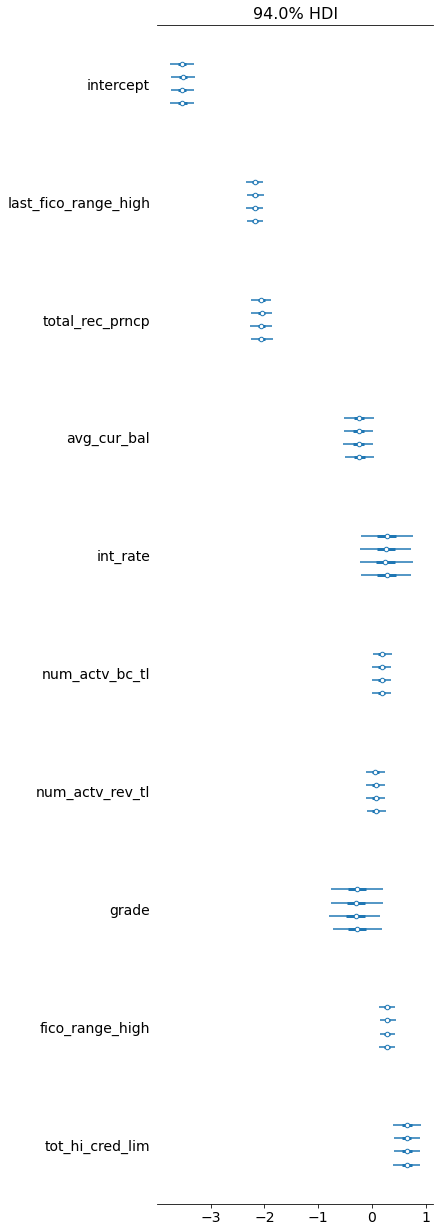

In [45]:
az.plot_forest(trace_full_sample, var_names=['intercept','last_fico_range_high','total_rec_prncp',
                  'avg_cur_bal','int_rate',
                 'num_actv_bc_tl','num_actv_rev_tl','grade','fico_range_high','tot_hi_cred_lim']);

#### Prediction Results

In [46]:
soft_classification = trace_full_sample['theta'].mean(axis=0)
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n


0.9194378463974664

In [47]:
sklearn.metrics.confusion_matrix(data_selected['loan_status'],hard_classification )

array([[3866,  180],
       [ 227,  779]])

## Reduced Logistic Regression Model

Created by removing not useful predictors with credible intervals overlapping 0 in the full model above

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tot_hi_cred_lim, fico_range_high, num_actv_bc_tl, total_rec_prncp, last_fico_range_high, intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


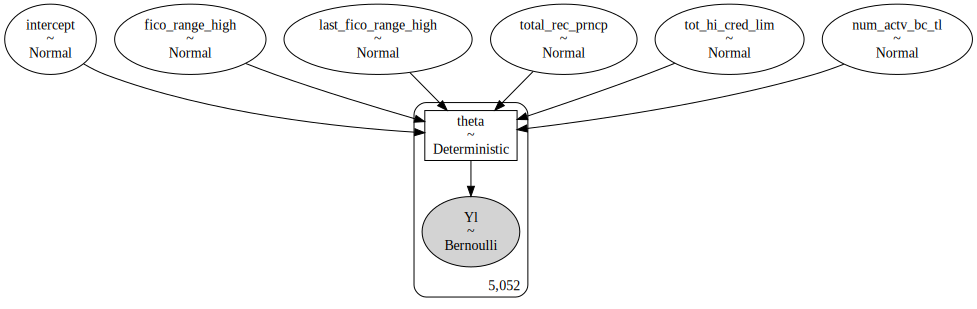

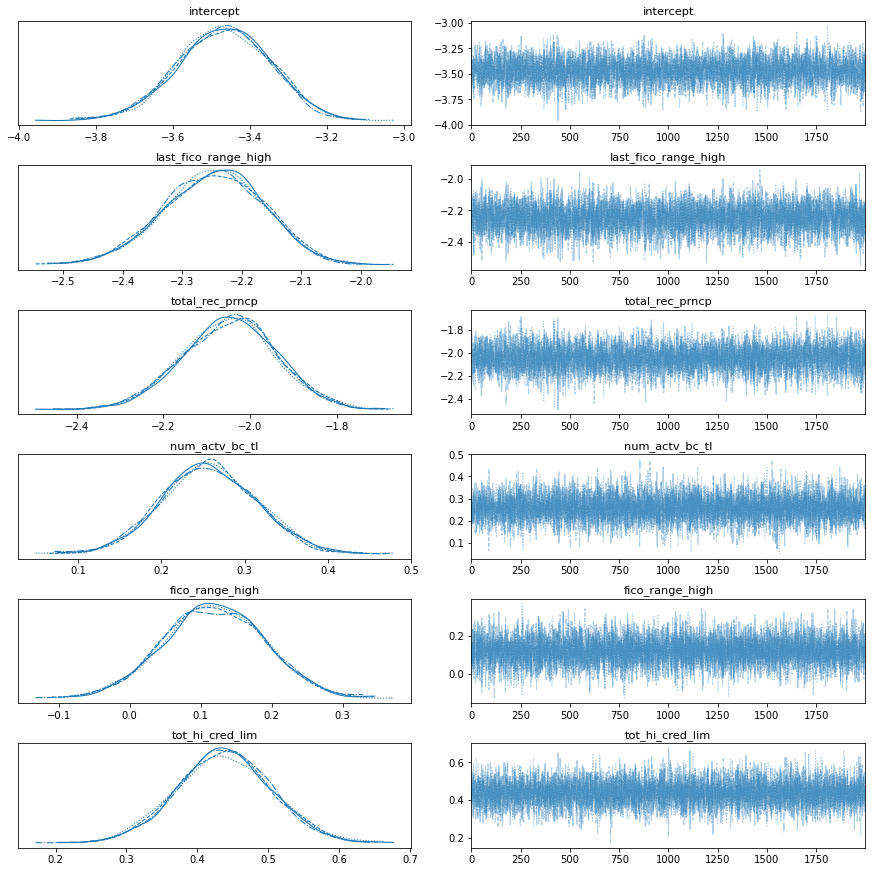

In [48]:
# Reduced Model Setup
with pm.Model() as reduced_model_sample:
    y = data_selected['loan_status']
    # Model Betas as uninformed gaussians
    b0 = pm.Normal('intercept', mu=0, sd=1e5) 
    b1 = pm.Normal('last_fico_range_high', mu=0, sd=1e5) 
    b2 = pm.Normal('total_rec_prncp', mu=0, sd=1e5)  
    b3 = pm.Normal('num_actv_bc_tl', mu=0, sd=1e5)
    b4 = pm.Normal('fico_range_high', mu=0, sd=1e5)
    b5 = pm.Normal('tot_hi_cred_lim', mu=0, sd=1e5)
    # Calculate mu
    mu = b0 + pm.math.dot(data_selected["last_fico_range_high"], b1)+ \
    pm.math.dot(data_selected["total_rec_prncp"], b2)+  pm.math.dot(data_selected["num_actv_bc_tl"], b3) + \
    pm.math.dot(data_selected["fico_range_high"], b4) + pm.math.dot(data_selected["tot_hi_cred_lim"], b5)
    # Use inv logit function
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Calculate bernoulli
    yl = pm.Bernoulli('Yl', p=theta, observed=y)
    trace_reduced_sample = pm.sample(2000, tune=1000, init='adapt_diag', cores =4)
    pm.traceplot(trace_reduced_sample,var_names=['intercept','last_fico_range_high','total_rec_prncp','num_actv_bc_tl','fico_range_high',
                                                'tot_hi_cred_lim'])
pm.model_to_graphviz(reduced_model_sample)

#### Prediction Results

In [49]:
soft_classification = trace_reduced_sample['theta'].mean(axis=0)
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n

0.9121140142517815

In [50]:
sklearn.metrics.confusion_matrix( data_selected['loan_status'], hard_classification)

array([[3859,  187],
       [ 257,  749]])

### Hierarchical Model

In [51]:
num_ownership = len(data_selected['home_ownership'].unique())
ownership = data_selected['home_ownership']
with pm.Model() as hierarchical_logistic_model:
    y = data_selected['loan_status']

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e2)
    sigma_a = pm.Normal("sigma_a",  mu=0., sd=1e2)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e2)
    sigma_b = pm.Normal("sigma_b",  mu=0., sd=1e2)

    # Random intercepts
    a = pm.Normal('intercept', mu=mu_a, sd=sigma_a, shape=num_ownership)
    # Random slopes
    b1 = pm.Normal('last_fico_range_high', mu=mu_b, sd=sigma_b, shape=num_ownership) 
    b2 = pm.Normal('total_rec_prncp', mu=mu_b, sd=sigma_b, shape=num_ownership)  
    b3 = pm.Normal('num_actv_bc_tl', mu=mu_b, sd=sigma_b, shape=num_ownership)
    b4 = pm.Normal('fico_range_high', mu=mu_b, sd=sigma_b, shape=num_ownership)
    b5 = pm.Normal('tot_hi_cred_lim', mu=mu_b, sd=sigma_b, shape=num_ownership)
    mu = a[ownership] + b1[ownership] * data_selected['last_fico_range_high'] + \
                                                b2[ownership] * data_selected['total_rec_prncp']+ \
                                               b3[ownership] * data_selected['num_actv_bc_tl'] + \
                                               b4[ownership] * data_selected['fico_range_high'] + \
                                               b5[ownership] * data_selected['tot_hi_cred_lim']
   # mu = a[ownership] +  pm.math.dot(data_selected['total_rec_prncp'], b2[ownership]) 
    # Use inv logit function
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Calculate bernoulli
    yl = pm.Bernoulli('Yl', p=theta, observed=y)
#     trace_reduced_sample = pm.sample(2000, tune=1000, init='adapt_diag')

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


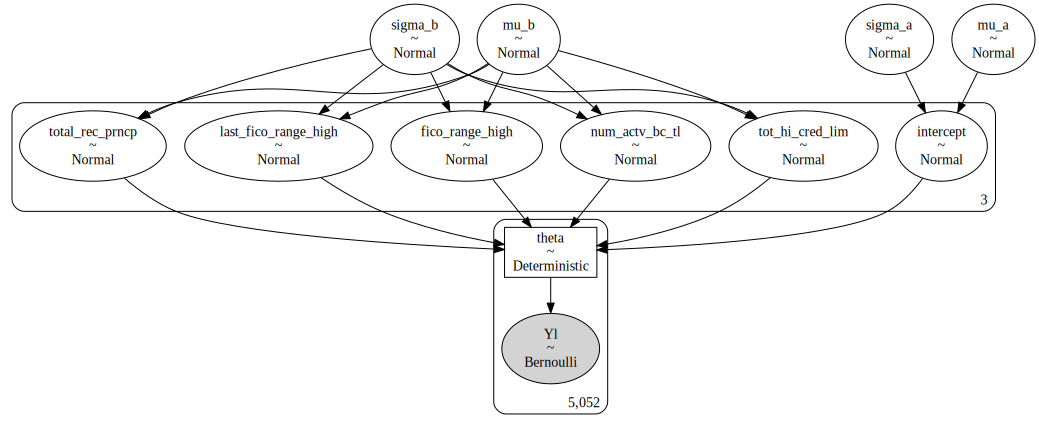

In [52]:
pm.model_to_graphviz(hierarchical_logistic_model)

In [53]:
with hierarchical_logistic_model: 
    hier_approx = pm.fit(50000, method = 'advi')

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Finished [100%]: Average Loss = 1,096.9


In [54]:
advi_hier_trace = hier_approx.sample(5000)

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [55]:
advi_hier_trace['last_fico_range_high']

array([[-2.07336045, -2.4816288 , -2.27106372],
       [-2.06651155, -2.4397157 , -2.24752416],
       [-2.00411023, -2.35115815, -1.90224869],
       ...,
       [-2.1538587 , -2.42328371, -2.1310323 ],
       [-2.21949988, -2.35636734, -2.31153921],
       [-2.0293231 , -2.33693943, -1.87622597]])

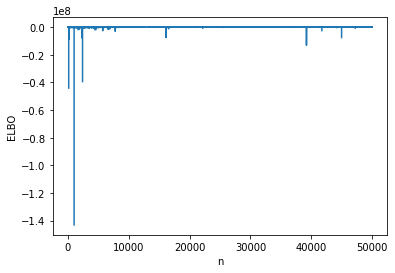

In [56]:
advi_elbo = pd.DataFrame(
    {'ELBO': -hier_approx.hist,
     'n': np.arange(hier_approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


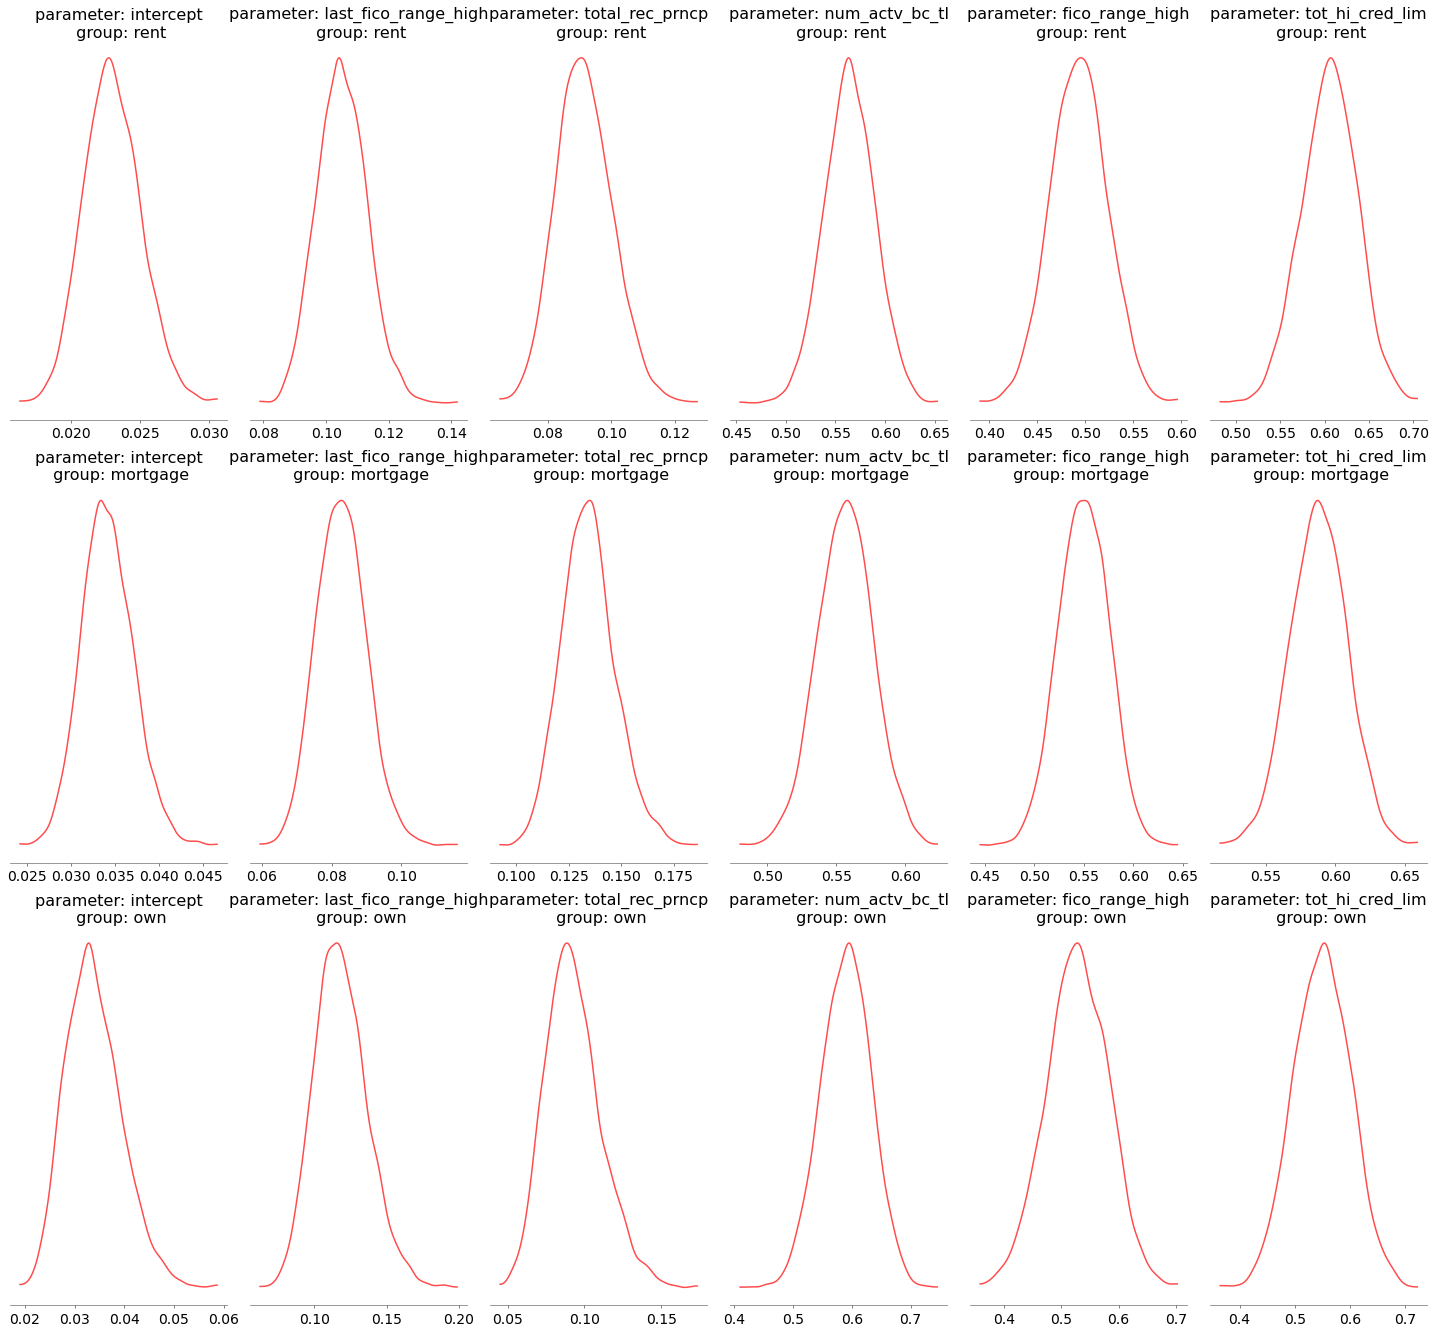

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=6,nrows=3,figsize=(20,20))
# Plot
lookup = {0:'rent',1:'mortgage',2:'own'}
hierachical_fit_trace_sample = hier_approx.sample(5000)
params = range(num_ownership)
parameters = ['intercept','last_fico_range_high','total_rec_prncp','num_actv_bc_tl','fico_range_high','tot_hi_cred_lim']
indexes = [(j,i) for i in range(3) for j in range(len(parameters))]
for i,param in enumerate(params):
    for j,parameter in enumerate(parameters):
        axInd = indexes[i]
        trace_fit = hierachical_fit_trace_sample[parameter]
        #pm.plot_posterior((np.exp(trace_sample[:,param]) / (1 + np.exp(trace_sample[:,param]))), ax=axs[axInd[0]][axInd[1]],point_estimate=None,  alpha=0.7)
        pm.plot_posterior((np.exp(trace_fit[:,param]) / (1 + np.exp(trace_fit[:,param]))),color='red',  ax=axs[i][j],point_estimate=None,hdi_prob= 'hide', alpha=0.7)
        axs[i][j].title.set_text(f'parameter: {parameter}\n group: {lookup[i]}')
        #axs[i][j].set_xlim(0,1)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
plt.show()   

#### Prediction Results

In [58]:
soft_classification = hierachical_fit_trace_sample['theta'].mean(axis=0)
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n

0.9142913697545526

In [59]:
sklearn.metrics.confusion_matrix( data_selected['loan_status'], hard_classification)

array([[3862,  184],
       [ 249,  757]])

## Bayesian Model Averaging

In [60]:
# Model comparisons with WAIC and weights

cmp_df = az.compare({'model_full':trace_full_sample, 'model_reduced':trace_reduced_sample,'model_hierarchical':hierachical_fit_trace_sample}, ic = 'WAIC',
                    method='BB-pseudo-BMA')
# Model weights
cmp_df

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnin

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_full,0,-999.976,10.5056,0,0.999967,36.433,0,False,log
model_reduced,1,-1035,6.55178,35.0249,1.91724e-06,36.8698,8.69676,False,log
model_hierarchical,2,-1040.48,21.6313,40.508,3.08911e-05,37.4975,9.93395,True,log


In [61]:
# Computing predictions by combining the models using the WAIC weights

#np.exp(-0.5*waic_p[0])/(np.exp(-0.5*waic_l[0]) + np.exp(-0.5*waic_p[0]))
# or use the value given in the table
w_full= cmp_df.loc['model_full','weight']
w_reduced= cmp_df.loc['model_reduced','weight']
w_hierarchical= cmp_df.loc['model_hierarchical','weight']

weights = [w_full,w_reduced,w_hierarchical]

In [62]:
# BMA Model
y_bma = pm.sample_posterior_predictive_w(traces = [trace_full_sample,trace_reduced_sample,hierachical_fit_trace_sample],
                                        samples=1000,
                                        models=[full_model_sample, reduced_model_sample,hierarchical_logistic_model],
                                        weights=weights)
# Full Model
y_full = pm.sample_posterior_predictive_w(traces = [trace_full_sample],
                                        samples=1000,
                                         models=[full_model_sample])
# Reduced
y_reduced = pm.sample_posterior_predictive_w(traces = [trace_reduced_sample],
                                        samples=1000,
                                        models=[ reduced_model_sample])

# Hierarchical
y_hierarchical= pm.sample_posterior_predictive_w(traces = [hierachical_fit_trace_sample],
                                        samples=1000,
                                        models=[ hierarchical_logistic_model])

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<AxesSubplot:>

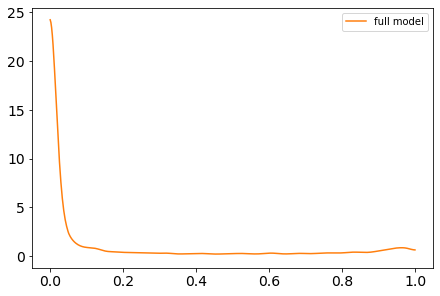

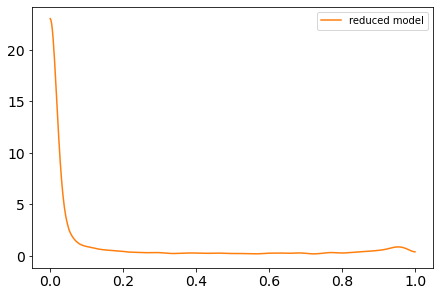

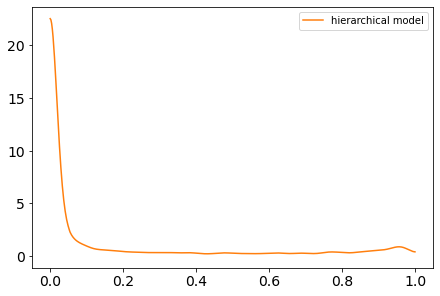

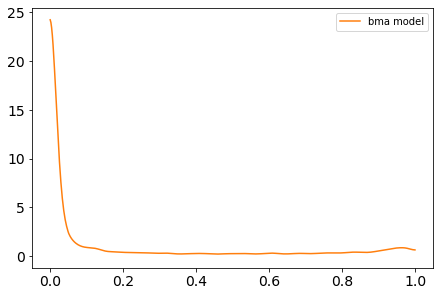

In [63]:
az.plot_kde(trace_full_sample['theta'].mean(axis=0), plot_kwargs={'color': 'C1'}, label='full model',)
az.plot_kde(trace_reduced_sample['theta'].mean(axis=0), plot_kwargs={'color': 'C1'}, label='reduced model',)
az.plot_kde(hierachical_fit_trace_sample['theta'].mean(axis=0), plot_kwargs={'color': 'C1'}, label='hierarchical model',)
theta_bma = trace_full_sample['theta'].mean(axis=0)*weights[0]+ trace_reduced_sample['theta'].mean(axis=0)*weights[1] + hierachical_fit_trace_sample['theta'].mean(axis=0)*weights[2] 
az.plot_kde(theta_bma, plot_kwargs={'color': 'C1'}, label='bma model',)

#### Prediction Results

In [64]:
soft_classification = theta_bma
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n

0.9194378463974664

In [65]:
sklearn.metrics.confusion_matrix( data_selected['loan_status'], hard_classification)

array([[3866,  180],
       [ 227,  779]])